### Validate CDSS Against NEST Study

For each patient week we compare the clinicians decisions took vs the decisions the CDSS engine would have taken.

---

In [2]:
nest_patient = [
    775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
    2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
]

In [3]:
rgs_mode = "app"
scoring_weights = [1,1,1]
ewma_alpha = 0.5

n = 12
days = 7
protocols_per_day = 5

### 1. Load Data

In [4]:
from ai_cdss.data_loader import DataLoader
from ai_cdss.data_processor import DataProcessor

In [5]:
loader = DataLoader(rgs_mode=rgs_mode)
processor = DataProcessor(weights=scoring_weights, alpha=ewma_alpha)

In [6]:
session = loader.load_session_data(patient_list=nest_patient)
timeseries = loader.load_timeseries_data(patient_list=nest_patient)
ppf = loader.load_ppf_data(patient_list=nest_patient)
protocol_similarity = loader.load_protocol_similarity()

Database engine created successfully


INFO:ai_cdss.data_loader:Session data loaded successfully.


Database engine closed
Database engine created successfully
Database engine closed
Database engine created successfully


INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.


Database engine closed


In [7]:
session_clean = session.drop(session.columns[1:15], axis=1)

In [9]:
# Get nest data merged with metrics semi computed
data = processor.merge_session_and_timeseries(session_data=session_clean, timeseries_data=timeseries)

AttributeError: 'DataProcessor' object has no attribute 'merge_session_and_timeseries'

In [ ]:
from ai_cdss.processing import expand_session_batch
session_all = expand_session_batch(session)
session_all_clean = session_all.drop(session_all.columns[1:15], axis=1)

### 1.2 Weekly Data

In [8]:
import pandas as pd

def iterate_cumulative_weekly_data(df):
    """
    Iterates over patient session data on a cumulative weekly basis.

    Parameters:
        df (pd.DataFrame): DataFrame containing session records with 'SESSION_DATE'.

    Yields:
        tuple: (week_number, cumulative_dataframe)
    """
    # Ensure SESSION_DATE is in datetime format
    df = df.copy()  # Create a new DataFrame to avoid modifying the original
    df["SESSION_DATE"] = pd.to_datetime(df["SESSION_DATE"], errors="coerce")

    # Drop rows where SESSION_DATE is NaT (missing)
    df = df.dropna(subset=["SESSION_DATE"]).copy()

    # Create 'YEAR_WEEK' column safely
    df.loc[:, "YEAR_WEEK"] = df["SESSION_DATE"].dt.strftime('%Y-%W')

    # Sort by date to ensure cumulative computation is correct
    df = df.sort_values(by="SESSION_DATE").copy()

    # Track cumulative data
    cumulative_df = pd.DataFrame()

    # Ensure unique weeks are sorted correctly
    for week in sorted(df["YEAR_WEEK"].dropna().astype(str).unique()):
        # Select all data up to the current week
        current_data = df[df["YEAR_WEEK"] <= week]
        
        # Append to cumulative dataset
        cumulative_df = pd.concat([cumulative_df, current_data]).drop_duplicates()

        yield week, cumulative_df.copy()  # Return a copy to prevent modification issues

def iterate_weekly_data(df):
    """
    Iterates over weekly patient session data.

    Parameters:
        df (pd.DataFrame): DataFrame containing session records with a 'SESSION_DATE' column.

    Yields:
        tuple: (week_number, weekly_dataframe)
    """
    # Ensure SESSION_DATE is datetime format
    df["SESSION_DATE"] = pd.to_datetime(df["SESSION_DATE"])

    # Create a 'YEAR_WEEK' column to group by year and week
    df["YEAR_WEEK"] = df["SESSION_DATE"].dt.strftime('%Y-%W')

    # Iterate through each week's data
    for week, weekly_df in df.groupby("YEAR_WEEK"):
        yield week, weekly_df

In [9]:
from ai_cdss.cdss import CDSS
import matplotlib.pyplot as plt

In [ ]:
score.dtypes

In [10]:
seen_weeks = []
patient_first_week_index = {}

all_scores = []

for week, cumulative_week_data in iterate_cumulative_weekly_data(data):
    print(week)

    # Add week to ordered list if new
    if week not in seen_weeks:
        seen_weeks.append(week)

    week_index = seen_weeks.index(week)

    # Register first appearance of patients from cumulative data (not score)
    for patient_id in cumulative_week_data['PATIENT_ID'].unique():
        if patient_id not in patient_first_week_index:
            patient_first_week_index[patient_id] = week_index

    # Compute scores
    score = processor.compute_patient_protocol_scores(data=cumulative_week_data, ppf_data=ppf)

    # Compute patient-relative week
    def compute_relative_week(pid):
        if pid in patient_first_week_index:
            return week_index - patient_first_week_index[pid]
        else:
            print(f"[Warning] Patient {pid} not found in first_week_index (possibly only in score).")
            return None

    score['week'] = score['PATIENT_ID'].map(compute_relative_week)
    score['absolute_week'] = week

    all_scores.append(score)

# Concatenate all score DataFrames
all_scores_df = pd.concat(all_scores, ignore_index=True)
display(all_scores_df)

2024-13
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (possibly only in score).
[Warning] Patient 788 not found in first_week_index (pos

,PATIENT_ID,PROTOCOL_ID,PPF,CONTRIB,ADHERENCE,DM_VALUE,PE_VALUE,USAGE,DAYS,SCORE,week,absolute_week
0,775,10,0.383888,"[0.0, 0.0, 0.0, 0.09743346255755155, 0.2864543...",0.0,0.0,0.0,0,0,0.383888,0.0,2024-13
1,775,200,0.358752,"[0.0, 0.0, 0.0, 0.07597986781430996, 0.2233808...",0.0,0.0,0.0,0,0,0.358752,0.0,2024-13
2,775,201,0.632038,"[0.022302696143133578, 0.07434232047711194, 0....",0.0,0.0,0.0,0,0,0.632038,0.0,2024-13
3,775,202,0.707386,"[0.0, 0.10411017707694051, 0.07808263280770539...",0.0,0.0,0.0,0,0,0.707386,0.0,2024-13
4,775,203,0.683612,"[0.0, 0.0798716715027359, 0.05990375362705192,...",0.0,0.0,0.0,0,0,0.683612,0.0,2024-13
...,...,...,...,...,...,...,...,...,...,...,...,...
23245,3432,229,0.531499,"[0.0, 0.0, 0.0, 0.15944962970727955, 0.3720491...",0.0,0.0,0.0,0,0,0.531499,NaN,2025-00
23246,3432,230,0.587271,"[0.0, 0.0, 0.0, 0.18964040409231936, 0.3318707...",0.0,0.0,0.0,0,0,0.587271,NaN,2025-00
23247,3432,231,0.546695,"[0.0, 0.0, 0.0, 0.2139241266075882, 0.33277086...",0.0,0.0,0.0,0,0,0.546695,NaN,2025-00
23248,3432,232,0.531499,"[0.0, 0.0, 0.0, 0.15944962970727955, 0.3720491...",0.0,0.0,0.0,0,0,0.531499,NaN,2025-00


In [1]:
score

NameError: name 'score' is not defined

In [11]:
all_scores_df.dropna(subset="week", inplace=True)

In [ ]:
# all_scores_df[all_scores_df["PATIENT_ID"]==775][all_scores_df["week"]==0].PPF.mean()

In [ ]:
all_scores_df

In [12]:
scores_filtered = all_scores_df.iloc[:,[0,1,4,5,7,8,10,9]]

In [13]:
patient_775 = scores_filtered[scores_filtered["PATIENT_ID"] == 775]

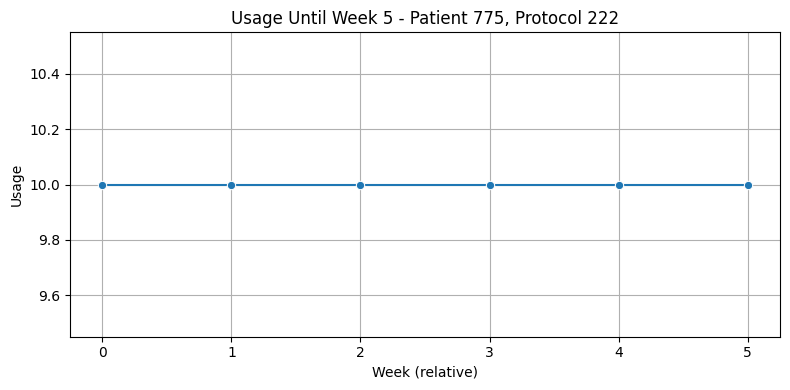

In [15]:
import seaborn as sns
patient_id = 775
protocol_id = 222

# Filter the data
subset = all_scores_df[
    (all_scores_df["PATIENT_ID"] == patient_id) &
    (all_scores_df["PROTOCOL_ID"] == protocol_id) &
    (all_scores_df["week"] <= 5)
]

# Plot usage over time
plt.figure(figsize=(8, 4))
sns.lineplot(data=subset, x="week", y="USAGE", marker="o")
plt.title(f"Usage Until Week 5 - Patient {patient_id}, Protocol {protocol_id}")
plt.xlabel("Week (relative)")
plt.ylabel("Usage")
plt.xticks(range(0, 6))  # Show ticks from 0 to 5
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
all_scores_df[all_scores_df["PATIENT_ID"]==775][all_scores_df["PROTOCOL_ID"]==222]

In [ ]:
i = 0
for week, cumulative_week_data in iterate_cumulative_weekly_data(data):
    # display(cumulative_week_data)  # Show last few rows
    # display(cumulative_week_data.tail())
    print(week)
    
    score = processor.compute_patient_protocol_scores(data=cumulative_week_data, ppf_data=ppf)
    
    display(score)
    
    # plt.hist(score[score.PATIENT_ID == 1123].PPF.values, bins=25)
    # plt.show()

    # cdss = CDSS(scoring=score, n=n, days=days, protocols_per_day=protocols_per_day)

    # display(cdss.get_prescriptions(775))

    # recommendation = cdss.recommend(775, protocol_similarity=protocol_similarity)

    # print("-----------------")

    # display(recommendation)

    i += 1
    if i==5:
        break

### Comparison

Trim by week, get prescriptions clinicians on sunday, get recommended prescriptions, compare

In [ ]:
df_sum = (
    all_scores_df
    .groupby(['PATIENT_ID', 'week'], as_index=False)
    [score_col]
    .sum()
)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_score_increase(df):
    # Choose the score column (update if yours has a different name)
    score_col = 'SCORE'  # ← replace with the correct column name if different

    # Set plot style
    sns.set(style="whitegrid", palette="muted", font_scale=1.1)

    plt.figure(figsize=(12, 6))

    # Lineplot: one line per patient
    sns.lineplot(
        data=df,
        x="week",
        y=score_col,
        hue="PATIENT_ID",
        marker="o"
    )

    plt.title("Patient Score Progression Over Weeks")
    plt.xlabel("Patient-relative Week Index")
    plt.ylabel("Score")
    plt.legend(title="Patient ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_score_increase(all_scores_df)
plot_score_increase(df_sum)

In [ ]:
plot_score_increase(patient_775)

In [ ]:
deltas = df_sum.groupby("PATIENT_ID")["SCORE"].agg(["first", "last"])
deltas["delta"] = deltas["last"] - deltas["first"]

In [ ]:
sns.kdeplot(deltas["delta"], fill=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("KDE of Total Score Change")
plt.xlabel("ΔScore")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

trends = []

# Fit linear model to get slope for each patient
for pid, group in all_scores_df.groupby("PATIENT_ID"):
    x = group["week"].values.reshape(-1, 1)
    y = group["SCORE"].values
    if len(x) > 1:
        model = LinearRegression().fit(x, y)
        slope = model.coef_[0]
        trends.append(slope)

# Plot distribution of slopes
plt.figure(figsize=(8, 4))
sns.histplot(trends, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Weekly Score Increase Rates (Slopes)")
plt.xlabel("Slope (ΔScore / Week)")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

In [ ]:
first_weeks = (
    all_scores_df
    .loc[all_scores_df["week"] == 0, ["PATIENT_ID", "absolute_week"]]
    .drop_duplicates(subset="PATIENT_ID")
    .reset_index(drop=True)
)

display(first_weeks)
